# Get started with MLX for Apple silicon

### Basics operations

In [1]:
import mlx.core as mx

# Make an array
a = mx.array([1, 2, 3])

# Make another array
b = mx.array([4, 5, 6])

# Do an operation
c = a + b

# Access information about the array
shape = c.shape
dtype = c.dtype

print(f"Result c: {c}")
print(f"Shape: {shape}")
print(f"Data type: {dtype}")

Result c: array([5, 7, 9], dtype=int32)
Shape: (3,)
Data type: mlx.core.int32


### Unified Memory

In [2]:
import mlx.core as mx

a = mx.array([1, 2, 3])
b = mx.array([4, 5, 6])

c = mx.add(a, b, stream=mx.gpu)
d = mx.multiply(a, b, stream=mx.cpu)

print(f"c computed on the GPU: {c}")
print(f"d computed on the CPU: {d}")

c computed on the GPU: array([5, 7, 9], dtype=int32)
d computed on the CPU: array([4, 10, 18], dtype=int32)


### Lazy computation

In [3]:
import mlx.core as mx

# Make an array
a = mx.array([1, 2, 3])

# Make another array
b = mx.array([4, 5, 6])

# Do an operation
c = a + b

# Evaluates c before printing it
print(c)

# Also evaluates c
c_list = c.tolist()

# Also evaluates c
mx.eval(c)

print(f"Evaluate c by converting to list: {c_list}")
print(f"Evaluate c using print: {c}")
print(f"Evaluate c using mx.eval(): {c}")

array([5, 7, 9], dtype=int32)
Evaluate c by converting to list: [5, 7, 9]
Evaluate c using print: array([5, 7, 9], dtype=int32)
Evaluate c using mx.eval(): array([5, 7, 9], dtype=int32)


### Function transformation

In [4]:
import mlx.core as mx

def sin(x):
    return mx.sin(x)

dfdx = mx.grad(sin)

def sin(x):
    return mx.sin(x)

d2fdx2 = mx.grad(mx.grad(mx.sin))

# Computes the second derivative of sine at 1.0
d2fdx2(mx.array(1.0))

array(-0.841471, dtype=float32)

#### Visualizing `sin`, `grad(sin)`,  `grad(grad(sin))`
Plot should show `sin(x)`, `cos(x)` and `-sin(x)`

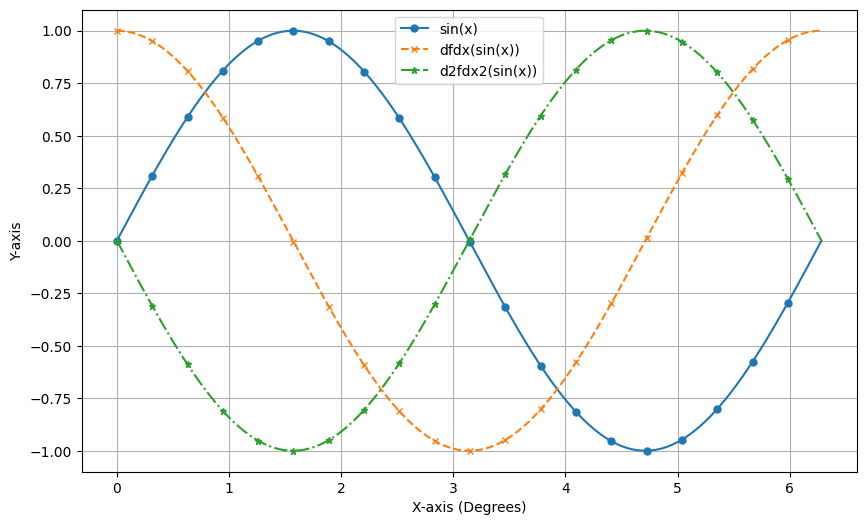

In [5]:
import matplotlib.pyplot as plt

def plot_waves(x, fn1, fn2, fn3, labels):

    # Generate y values for sin(x) and dfdx(sin(x))
    y_1 = fn1(x)
    y_2 = fn2(x)
    y_3 = fn3(x)

    # Create the plot
    plt.figure(figsize=(10, 6))
    # Note: x is already in degrees here for plotting
    plt.plot(x, y_1, label=labels[0], marker='o', linestyle='-', markersize=5, markevery=20)
    plt.plot(x, y_2, label=labels[1], marker='x', linestyle='--', markersize=5, markevery=20)
    plt.plot(x, y_3, label=labels[2], marker='*', linestyle='-.', markersize=5, markevery=20)

    # Add labels
    plt.xlabel('X-axis (Degrees)') # Changed label here
    plt.ylabel('Y-axis')

    plt.legend()
    plt.grid(True)
    plt.show()


x = mx.linspace(0, 2 * mx.pi, 400)

cos = mx.vmap(dfdx)
negative_sin = mx.vmap(d2fdx2)

plot_waves(x, sin, cos, negative_sin, ["sin(x)","dfdx(sin(x))", "d2fdx2(sin(x))"])

### Neural Networks in MLX and Pytorch

MLX Neural Network

In [6]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

class MLP(nn.Module):
    """A simple MLP."""

    def __init__(self, dim, h_dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, h_dim)
        self.linear2 = nn.Linear(h_dim, dim)

    def __call__(self, x):
        x = self.linear1(x)
        x = nn.relu(x)
        x = self.linear2(x)
        return x

MLX Training loop

In [7]:
n_epochs = 5
input_dim, hidden_dim, num_samples = 10, 50, 1000

model = MLP(input_dim, hidden_dim)

def loss_fn(model, X, y):
    return nn.losses.mse_loss(model(X), y)

loss_and_grad_fn = nn.value_and_grad(model, loss_fn)
optimizer = optim.Adam(learning_rate=0.01)

X_train = mx.random.normal([num_samples, input_dim])
y_train = mx.random.normal([num_samples, input_dim])

for epoch in range(n_epochs):
    loss, grads = loss_and_grad_fn(model, X_train, y_train)
    model.update(optimizer.apply_gradients(grads, model))
    mx.eval(model.parameters(), optimizer.state) 

print(f"Final Loss after 5 steps: {loss.item():.4f}")

Final Loss after 5 steps: 1.0052


PyTorch Neural Network

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    """A simple MLP."""

    def __init__(self, dim, h_dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, h_dim)
        self.linear2 = nn.Linear(h_dim, dim)

    def forward(self, x):
        x = self.linear1(x)
        x = x.relu()
        x = self.linear2(x)
        return x

PyTorch Training loop

In [9]:
n_epochs = 5
input_dim, hidden_dim, num_samples = 10, 50, 1000
model = MLP(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

X_train = torch.randn([num_samples, input_dim])
y_train = torch.randn([num_samples, input_dim])

for epoch in range(n_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f"Final Loss after 5 steps: {loss.item():.4f}")

Final Loss after 5 steps: 1.0028


### Compiling MLX functions

In [10]:
import mlx.core as mx
import math

def gelu(x):
    return x * (1 + mx.erf(x / math.sqrt(2))) / 2

@mx.compile
def compiled_gelu(x):
    return x * (1 + mx.erf(x / math.sqrt(2))) / 2

x = mx.random.normal(shape=(4,))

out = gelu(x)
compiled_out = compiled_gelu(x)
print(f"gelu:          {out}")
print(f"compiled gelu: {compiled_out}")

gelu:          array([-0.169571, -0.0094711, 0.120888, -0.122945], dtype=float32)
compiled gelu: array([-0.169571, -0.0094711, 0.120888, -0.122945], dtype=float32)


### MLX Fast package

In [11]:
import mlx.core as mx

def rms_norm(x, weight, eps=1e-5):
    y = x.astype(mx.float32)
    y = y * mx.rsqrt(mx.mean(
        mx.square(y),
        axis=-1,
        keepdims=True,
    ) + eps)
    return (weight * y).astype(x.dtype)

feature_dim = 4

x = mx.random.normal((feature_dim,))
weight = mx.random.normal((feature_dim,))

y = rms_norm(x, weight, eps=1e-5)
y_fast = mx.fast.rms_norm(x, weight, eps=1e-5)

print(f"RMS norm:      {y}")
print(f"Fast RMS norm: {y_fast}")

RMS norm:      array([-1.47364, 0.545241, -0.767421, 0.140266], dtype=float32)
Fast RMS norm: array([-1.47364, 0.545241, -0.767421, 0.140266], dtype=float32)


### Custom Metal kernels

In [12]:
import mlx.core as mx

# Build the kernel
source = """
    uint elem = thread_position_in_grid.x;
    out[elem] = metal::exp(inp[elem]);
"""
kernel = mx.fast.metal_kernel(
    name="myexp",
    input_names=["inp"],
    output_names=["out"],
    source=source,
)

# Call the kernel on a sample input
x = mx.array([1.0, 2.0, 3.0])
out = kernel(
    inputs=[x],
    grid=(x.size, 1, 1),
    threadgroup=(256, 1, 1),
    output_shapes=[x.shape],
    output_dtypes=[x.dtype],
)[0]
print(out)

array([2.71828, 7.38906, 20.0855], dtype=float32)


### Quantization

In [13]:
import mlx.core as mx

x = mx.random.normal([1024])
weight = mx.random.normal([1024, 1024])

quantized_weight, scales, biases = mx.quantize(
        weight, bits=4, group_size=32,
)

y = mx.quantized_matmul(
    x,
    quantized_weight,
    scales=scales,
    biases=biases,
    bits=4,
    group_size=32,
)

w_orig = mx.dequantize(
    quantized_weight,
    scales=scales,
    biases=biases,
    bits=4,
    group_size=32,
)


In [14]:
import mlx.nn as nn

model = nn.Sequential(
    nn.Embedding(100, 32),
    nn.Linear(32, 32),
    nn.Linear(32, 32),
    nn.Linear(32, 1),
)

print(model)

nn.quantize(
    model,
    bits=4,
    group_size=32,
)

print(model)

Sequential(
  (layers.0): Embedding(100, 32)
  (layers.1): Linear(input_dims=32, output_dims=32, bias=True)
  (layers.2): Linear(input_dims=32, output_dims=32, bias=True)
  (layers.3): Linear(input_dims=32, output_dims=1, bias=True)
)
Sequential(
  (layers.0): QuantizedEmbedding(100, 32, group_size=32, bits=4)
  (layers.1): QuantizedLinear(input_dims=32, output_dims=32, bias=True, group_size=32, bits=4)
  (layers.2): QuantizedLinear(input_dims=32, output_dims=32, bias=True, group_size=32, bits=4)
  (layers.3): QuantizedLinear(input_dims=32, output_dims=1, bias=True, group_size=32, bits=4)
)


In [15]:
import mlx.core as mx

group = mx.distributed.init()

world_size = group.size()
rank = group.rank()

x = mx.array([1.0])

x_sum = mx.distributed.all_sum(x)

print(x_sum)

array([1], dtype=float32)
